# Importing Datasets

In [ ]:
import urllib.request
from zipfile import ZipFile
import numpy as np
from glob import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import torch
import torchvision.models as models
from PIL import Image , ImageFile
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#ZipFile("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/dogImages.zip").extractall("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN")
#ZipFile("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/lfw.zip").extractall("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN")

In [ ]:
# changing the current directory
os.chdir("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN")
cwd = os.getcwd()
print("Current working directory is:", cwd)

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

Current working directory is: /content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN
There are 13233 total human images.
There are 8351 total dog images.


# Detecting Humans

Number of detected faces :  1


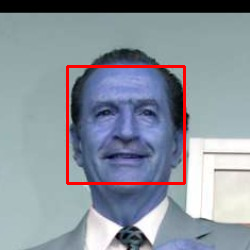

In [ ]:
# extract pretrained face detector
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/haarcascades/haarcascade_frontalface_alt.xml")

# Load RGB image
img = cv2.imread(human_files[0])

# convert BGR image to greyscale
gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY )

# find faces in images 
faces = face_cascade.detectMultiScale(gray)

# print no of detected faces in the image
print("Number of detected faces : ",len(faces))


# getting & adding bounding boxes for each detected face
for (x,y,w,h) in faces :
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

# Convert BGR image to RGB image
image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# displaying image, along with bounding box
cv2_imshow(image)


## Writ a Human Face Detector

In [ ]:
def face_detector(imgpath) :
 img = cv2.imread(imgpath)
 gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 faces = face_cascade.detectMultiScale(gray)
 return len(faces) > 0

## Assess the Human Face Detector

In [ ]:
human_files_short = np.array([human_files[i] for i in range(100)]) 
dog_files_short =  np.array([dog_files[i] for i in range(100)]) 

faces_in_human_files = np.mean(list(map(face_detector,human_files_short)))
faces_in_dog_files = np.mean(list(map(face_detector,dog_files_short)))

In [ ]:
print("detect face in human_files: {} / {}".format(int(faces_in_human_files *100), len(human_files_short)))
print("detect face in dog_files: {} / {}".format(int(faces_in_dog_files*100) , len(dog_files_short)))

detect face in human_files: 99 / 100
detect face in dog_files: 18 / 100


# Detect Dogs

## Obtain Pre-trained VGG-16 Model

In [ ]:
# checking CUDA availability
is_cuda_available = torch.cuda.is_available()
print("cuda available? {}".format(is_cuda_available))

cuda available? True


In [ ]:
 # define VGG model
VGG16 = models.vgg16(pretrained = True)

# move vgg to CUDA if available
if is_cuda_available :
  VGG16 = VGG16.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# preprocessing & loading image
def load_image(img_path) :
  image = Image.open(img_path)
  in_transform = transforms.Compose([
      transforms.Resize(size = (244,244)),
       transforms.ToTensor()])
  image = in_transform(image).unsqueeze(0)
  return image

In [ ]:
# predicting image class using pretrained VGG16 model
def VGG16_predict(img_path):
  image = load_image(img_path)
  if is_cuda_available :
    image = image.cuda()
  pred = VGG16(image)
  return torch.max(pred,1)[1].item()

In [ ]:
# predict dog using ImageNet class
VGG16_predict(dog_files_short[15])

160

The categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'.

In [ ]:
def dog_detector(img_path):
  pred = VGG16_predict(img_path)
  return ((pred >= 151) and (pred <= 268))

## Assess the Dog Detector

In [ ]:
dogs_in_human_files = np.mean(list(map(dog_detector,human_files_short))) * 100
dogs_in_dog_files = np.mean(list(map(dog_detector,dog_files_short))) * 100

print("detect a dog in human_files: {} / {}".format(int(dogs_in_human_files), len(human_files_short)))
print("detect a dog in dog_files: {} / {}".format(int(dogs_in_dog_files) , len(dog_files_short)))

detect a dog in human_files: 0 / 100
detect a dog in dog_files: 94 / 100


# Creating a CNN to Classify Dog Breeds (from Scratch)

## Preprocessing

In [ ]:
batch_size = 20
num_worker = 0

data_dir = "/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/dogImages"
train_dir = os.path.join(data_dir,"train/")
valid_dir = os.path.join(data_dir,"valid/")
test_dir = os.path.join(data_dir,"test/")

## User Standard Normalization Value

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    "val" : transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize
    ]),
    "test" : transforms.Compose([transforms.Resize(size=(224,224)),
                                 transforms.ToTensor(), 
                                 normalize
        
    ])
}

## Use ImageFolder to Load image_dataset

In [ ]:
train_data = datasets.ImageFolder(train_dir,transform = data_transforms["train"])
valid_data = datasets.ImageFolder(valid_dir, transform = data_transforms["val"] )
test_data = datasets.ImageFolder(test_dir,transform = data_transforms["test"] )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size , num_workers= num_worker , shuffle = True )
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size , num_workers= num_worker , shuffle = True )
test_loader = torch.utils.data.DataLoader(test_data , batch_size = batch_size , num_workers= num_worker , shuffle = True )
loaders_scratch = {
    "train" : train_loader ,
    "valid" : valid_loader ,
    "test" : test_loader
}

## Model Architecture

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_classes = 133 # total classes of dog breeds

In [ ]:
class Net(nn.Module) :
  def __init__(self):
    super(Net, self).__init__()
    
    # Define layers of a CNN
    self.conv1 = nn.Conv2d(3,32,3, stride = 2 , padding = 1)
    self.conv2 = nn.Conv2d(32,64,3,stride = 2 , padding = 1)
    self.conv3 = nn.Conv2d(64,128,3, padding = 1)
    
    # Define pooling layer
    self.pool = nn.MaxPool2d(2,2)

    # Define Fully connnected layer
    self.fc1 = nn.Linear(7*7*128 , 512)
    self.fc2 = nn.Linear(512 , num_classes)

    # Define dropout layer
    self.dropout = nn.Dropout(.3)

  def forward(self , x ) :
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    # Flatten
    x = x.view(-1,7*7*128)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if is_cuda_available:
    model_scratch = model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Specify Loss Function and Optimizer

In [ ]:
# Selecting loss function
criterion_scratch = nn.CrossEntropyLoss()

### Selecting optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.05)

## Train and Validate the Model

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
  # initialize tracker for minimum validation loss
    if last_validation_loss is not None :
      valid_loss_min = last_validation_loss
    else :
      valid_loss_min = np.Inf

    
    for epoch in range(1,n_epochs+1) :
      train_loss = 0.0
      valid_loss = 0.0

      # train the model #
      model.train()
      for batch_idx , (data,target) in enumerate(loaders["train"]) :
        if use_cuda :
          target = target.cuda()
          data = data.cuda() 
        
        # initialize weights to zero
        optimizer.zero_grad()

        output = model(data)

        # calculate loss 
        loss = criterion(output , target)

        # back prop
        loss.backward()

        # grad 
        optimizer.step()

        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        if batch_idx % 100 == 0 :
          print('Epoch %d, Batch %d loss: %.6f' %(epoch, batch_idx + 1, train_loss))


      # evaluate the model
      model.eval()
      for batch_idx , (data,target) in enumerate(loaders["valid"]) :
        if use_cuda :
          data , target = data.cuda() , target.cuda()

        output = model(data)
        loss = criterion(output , target)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


      # print training/validation statistics
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

      if valid_loss < valid_loss_min :
        torch.save(model.state_dict(),save_path)
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss

    return model

In [ ]:
model_scratch  = train(10, loaders_scratch , model_scratch, optimizer_scratch, criterion_scratch, is_cuda_available,"/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/saved_models/model_scratch.pt")

Epoch 1, Batch 1 loss: 4.896787
Epoch 1, Batch 101 loss: 4.887551
Epoch 1, Batch 201 loss: 4.882643
Epoch 1, Batch 301 loss: 4.876468
Epoch: 1 	Training Loss: 4.873130 	Validation Loss: 4.813134
Validation loss decreased (inf --> 4.813134).  Saving model ...
Epoch 2, Batch 1 loss: 4.817242
Epoch 2, Batch 101 loss: 4.801384
Epoch 2, Batch 201 loss: 4.791429
Epoch 2, Batch 301 loss: 4.782006
Epoch: 2 	Training Loss: 4.781073 	Validation Loss: 4.721021
Validation loss decreased (4.813134 --> 4.721021).  Saving model ...
Epoch 3, Batch 1 loss: 4.656778
Epoch 3, Batch 101 loss: 4.691680
Epoch 3, Batch 201 loss: 4.682076
Epoch 3, Batch 301 loss: 4.667571
Epoch: 3 	Training Loss: 4.661502 	Validation Loss: 4.524099
Validation loss decreased (4.721021 --> 4.524099).  Saving model ...
Epoch 4, Batch 1 loss: 4.898305
Epoch 4, Batch 101 loss: 4.574084
Epoch 4, Batch 201 loss: 4.580935
Epoch 4, Batch 301 loss: 4.574328
Epoch: 4 	Training Loss: 4.572579 	Validation Loss: 4.393412
Validation loss de

## Test the Model

In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/saved_models/model_scratch.pt"))

<All keys matched successfully>

In [ ]:
def test(loaders, model, criterion, use_cuda):
  test_loss = 0
  correct = 0
  total = 0
  # evaluate the model
  for batch_idx , (data,target) in enumerate(loaders["test"]) :
    if use_cuda :
      data , target = data.cuda() , target.cuda()

    output = model(data)
    loss = criterion(output , target)
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1,keepdim = True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0) 


  print('Test Loss: {:.6f}\n'.format(test_loss))
  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [ ]:
test(loaders_scratch, model_scratch, criterion_scratch, is_cuda_available)

Test Loss: 4.177154


Test Accuracy:  8% (67/836)


# Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

loaders_transfer = loaders_scratch.copy()

In [ ]:
# loading pretrained resnet50 model
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet50(pretrained = True)

In [ ]:
# freezing model parameters
for param in model_transfer.parameters() :
  param.requires_grad = False

In [ ]:
model_transfer.fc = nn.Linear(2048 ,133, bias = True)

In [ ]:
# adding an output layer for the pretrained model to classify output classes
fc_parameters = model_transfer.fc.parameters()

In [ ]:
for param in fc_parameters :
  param.requires_grad = True

In [ ]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
if is_cuda_available :
  model_transfer = model_transfer.cuda()

In [ ]:
import torch.nn as nn
import torch.optim as optim

# loss function
criterion_transfer = nn.CrossEntropyLoss()

# optimizer
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr = 0.001)

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  valid_loss_min = np.Inf

  for epoch in range(1 , n_epochs+1) :
    train_loss = 0.0 
    valid_loss = 0.0
    model.train()
    for batch_idx , (data,target) in enumerate(loaders["train"]) :
      if use_cuda :
        data , target = data.cuda() , target.cuda()

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
      train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

      if batch_idx % 100 == 0 :
        print('Epoch {}, Batch {} loss: {}'.format(epoch, batch_idx + 1, train_loss))

    model.eval()
    for batch_idx , (data,target) in enumerate(loaders["valid"]) :
      if use_cuda :
        data , target = data.cuda() , target.cuda()

      output = model(data)
      loss = criterion(output,target)
      valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    if valid_loss < valid_loss_min :
      torch.save(model.state_dict(),save_path)
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
      valid_loss_min = valid_loss

  return model

In [ ]:
#  model training using the predefined function
model_transfer  = train(20, loaders_transfer , model_transfer, optimizer_transfer, criterion_transfer, is_cuda_available,"/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/saved_models/model_transfer.pt")

Epoch 1, Batch 1 loss: 3.991248369216919
Epoch 1, Batch 101 loss: 3.989619255065918
Epoch 1, Batch 201 loss: 3.969146490097046
Epoch 1, Batch 301 loss: 3.94988751411438
Epoch: 1 	Training Loss: 3.945775 	Validation Loss: 3.424160
Validation loss decreased (inf --> 3.424160).  Saving model ...
Epoch 2, Batch 1 loss: 3.866492509841919
Epoch 2, Batch 101 loss: 3.883650302886963
Epoch 2, Batch 201 loss: 3.8471226692199707
Epoch 2, Batch 301 loss: 3.8243284225463867
Epoch: 2 	Training Loss: 3.814739 	Validation Loss: 3.228951
Validation loss decreased (3.424160 --> 3.228951).  Saving model ...
Epoch 3, Batch 1 loss: 3.8319764137268066
Epoch 3, Batch 101 loss: 3.7148540019989014
Epoch 3, Batch 201 loss: 3.696774959564209
Epoch 3, Batch 301 loss: 3.6760685443878174
Epoch: 3 	Training Loss: 3.670678 	Validation Loss: 3.024215
Validation loss decreased (3.228951 --> 3.024215).  Saving model ...
Epoch 4, Batch 1 loss: 3.5200023651123047
Epoch 4, Batch 101 loss: 3.591578722000122
Epoch 4, Batch 2

## Test the Model

In [ ]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load("/content/drive/MyDrive/Datasets/Dog Breed Classifier using CNN/saved_models/model_transfer.pt"))

<All keys matched successfully>

In [ ]:
test(loaders_scratch, model_transfer, criterion_transfer, is_cuda_available)

Test Loss: 1.463719


Test Accuracy: 73% (617/836)


# Predict Dog Breed with the Model

In [ ]:
class_names = [item[4:].replace("_"," ") for item in loaders_transfer["train"].dataset.classes]

In [ ]:
loaders_transfer["train"].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [ ]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# loading and preprocessing image
def load_input_image(img_path):
  image = Image.open(img_path)
  prediction_transform  = transforms.Compose([transforms.Resize(size = (224,224)),
                                   transforms.ToTensor(),
                                   normalize])
  image = prediction_transform(image).unsqueeze(0)
  return image

In [ ]:
# predicting dog breed
def predict_breed_transfer(model, class_names, img_path):
  img = load_input_image(img_path)
  model = model.cpu()
  model.eval()
  idx = torch.argmax(model(img))
  return class_names[idx]

In [ ]:
# predicting dog breed using the predefined function
for img_file in os.listdir("./images") :
  img_path = os.path.join("./images",img_file)
  predition = predict_breed_transfer(model_transfer , class_names ,img_path)
  print("image_file_name: {}, \t predition breed: {}".format(img_path, predition))

image_file_name: ./images/Brittany_02625.jpg, 	 predition breed: Brittany
image_file_name: ./images/Welsh_springer_spaniel_08203.jpg, 	 predition breed: Welsh springer spaniel
image_file_name: ./images/Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
image_file_name: ./images/Labrador_retriever_06455.jpg, 	 predition breed: Chesapeake bay retriever
image_file_name: ./images/Labrador_retriever_06449.jpg, 	 predition breed: Flat-coated retriever
image_file_name: ./images/Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
image_file_name: ./images/American_water_spaniel_00648.jpg, 	 predition breed: Irish water spaniel


# Final image classifier algorithm

Finally this algorithm should combine the workflow of the 2 defined algorithms,
It accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.

In [ ]:
import matplotlib.pyplot as plt

def run_app(img_path):
  image = Image.open(img_path)
  plt.imshow(image)
  plt.show()
  if dog_detector(img_path) == True :
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("Dogs Detected!\nIt looks like a {0}".format(prediction))
  elif face_detector(img_path) == True :
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
  else :
    print("Error! Can't detect anything..")

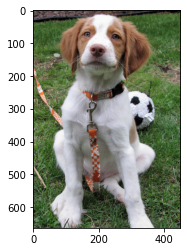

Dogs Detected!
It looks like a Brittany


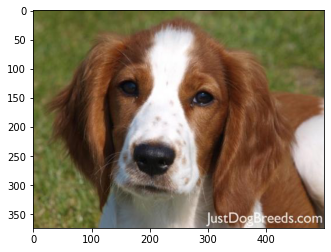

Dogs Detected!
It looks like a Welsh springer spaniel


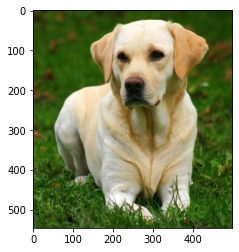

Dogs Detected!
It looks like a Labrador retriever


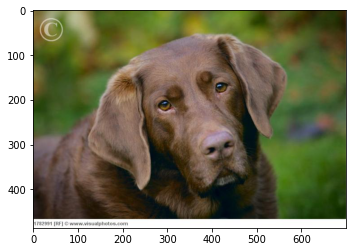

Dogs Detected!
It looks like a Chesapeake bay retriever


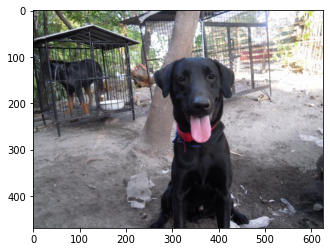

Dogs Detected!
It looks like a Flat-coated retriever


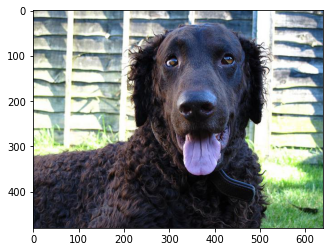

Dogs Detected!
It looks like a Curly-coated retriever


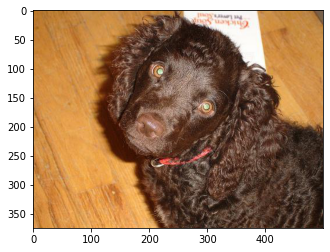

Dogs Detected!
It looks like a Irish water spaniel


In [ ]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

# Testing algorithm

In [ ]:
my_human_files = ['./my_images/human_1.jpg', './my_images/human_2.jpg', './my_images/human_3.jpg' ]
my_dog_files = ['./my_images/dog_shiba.jpeg', './my_images/dog_yorkshire.jpg', './my_images/dog_retreiver.jpg']

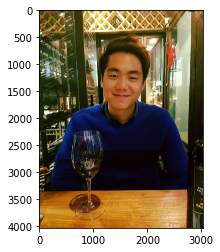

Hello, human!
If you were a dog..You may look like a Maltese


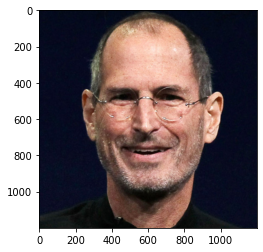

Hello, human!
If you were a dog..You may look like a Bull terrier


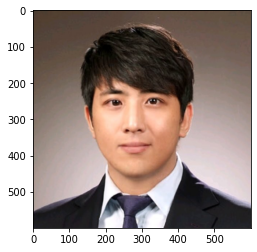

Hello, human!
If you were a dog..You may look like a Bichon frise


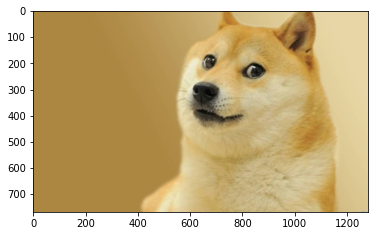

Dogs Detected!
It looks like a Akita


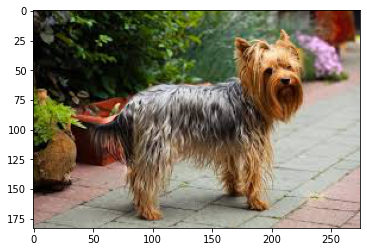

Dogs Detected!
It looks like a Australian terrier


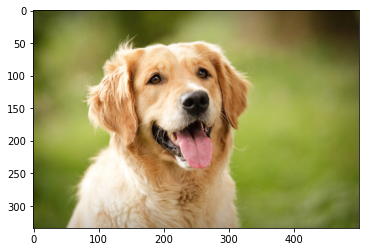

Dogs Detected!
It looks like a Golden retriever


In [ ]:
for image_path in np.hstack((my_human_files,my_dog_files)) :
  run_app(image_path)